# Part-01B: Preparing Amazon Reviews Home & Kitchen Subset

## Introduction

In this notebook, we focus on preparing a subset of Amazon reviews for the Home and Kitchen category. This involves several data preprocessing steps to ensure that the data is clean, relevant, and ready for detailed analysis. The main goals of this notebook are to filter and clean the data, combine reviews with metadata, and save the final subsets for further analysis.

#### Objectives

1. **Load and Combine Data**:
   - Efficiently load the raw review files and metadata for the Home and Kitchen category.
   - Combine the review and metadata files to create a unified dataset for analysis.

2. **Data Preprocessing**:
   - Filter the metadata to retain only relevant products.
   - Apply one-hot encoding to the categorical data.
   - Remove non-essential features to streamline the dataset.

3. **Create Meaningful Subsets**:
   - Identify products with sufficient review data for detailed analysis.
   - Group reviews by product, category, and other relevant features to focus the analysis on key items.

4. **Save the Final Subsets**:
   - Save the cleaned and filtered subsets of reviews and metadata for use in subsequent analysis steps.

By the end of this notebook, we will have a well-structured subset of Amazon reviews for the Home and Kitchen category, ready for in-depth analysis to extract valuable insights into customer preferences and sentiments.


In [69]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Load the Data

We will download our corpus of reviews and associated metadata for filtering.

In [70]:
## Import necessary packages
import pandas as pd
import nltk
import os, glob, json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth', 200)

In [71]:
import json, glob
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)
FPATHS['data']['cleaned']

{'reviews-by-years_dict': {'dir': 'data/reviews-by-year/',
  'glob': 'data/reviews-by-year/*.*'},
 'metadata_csv-gz': 'data/metadata/amazon-metadata-groceries-combined.csv.gz',
 'asin-id-title-dict_json': 'data/metadata/amazon-groceries-asin-titles-lookup.json'}

In [72]:
q = FPATHS['data']['cleaned']['reviews-by-years_dict']['glob']
review_files = sorted(glob.glob(q))
len(review_files)

17

In [73]:
# folder_in = "reviews-by-year/"
# # sorted(os.listdir("split/"))
# review_files = sorted(glob.glob(folder_in+"*.*csv*"))
# len(review_files)

In [74]:

## Load metadata for filtering/selecting
# fpath_meta = 'metadata/amazon-metadata-groceries-gourmet-combined.csv.gz'
fpath_meta = FPATHS['data']['cleaned']['metadata_csv-gz']
df_meta = pd.read_csv(fpath_meta)
df_meta.head(10)

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...",0,0,0,0,0,0,0,1,0,0,1,0,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"
1,B008QMX2SG,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...",0,0,0,0,0,0,0,1,0,0,1,0,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"
2,B00D3M2QP4,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...",0,0,0,0,0,0,0,1,0,0,0,0,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']"
3,B00542YXFW,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha","'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplem

In [75]:
df_meta.columns

Index(['asin', 'category', 'description', 'title', 'brand', 'feature', 'rank',
       'main_cat', 'price', 'imageURL', 'imageURLHighRes', 'details',
       'Category_Beverages', 'Category_Bottled Beverages, Water & Drink Mixes',
       'Category_Candy & Chocolate',
       'Category_Canned, Jarred & Packaged Foods', 'Category_Coffee',
       'Category_Coffee, Tea & Cocoa', 'Category_Cooking & Baking',
       'Category_Grocery & Gourmet Food',
       'Category_Herbs, Spices & Seasonings',
       'Category_Sauces, Gravies & Marinades', 'Category_Snack Foods',
       'Category_Tea', 'category_list'],
      dtype='object')

In [76]:
# Drop unwanted cols
drop_cols_meta = ['also_buy','also_view','category_list'] #'category'
df_meta = df_meta.drop(columns=drop_cols_meta, errors='ignore')
df_meta

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea
0,B00BUKL666,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...",0,0,0,0,0,0,0,1,0,0,1,0
1,B008QMX2SG,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...",0,0,0,0,0,0,0,1,0,0,1,0
2,B00D3M2QP4,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...",0,0,0,0,0,0,0,1,0,0,0,0
3,B00542YXFW,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha","'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diag...","Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag",Davidson's Tea,NaN,"100,853 in Grocery & Gourmet Food (",Grocery,$15.00,"'https://images-na.ssl-images-ama

### Cleaning Metadata

#### Category List 

In [77]:
# Confirm string not list
df_meta.loc[0,'category']

'Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars'

In [78]:
import ast
# Use ast.literal_eval to convert strings to actual lists
df_meta['category_list'] = df_meta['category'].str.split("; ")#map(ast.literal_eval)
df_meta.loc[0,'category_list']

['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']

In [79]:
df_meta['category'] = df_meta['category_list'].map(lambda x: "; ".join(x))
df_meta.head()

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...",0,0,0,0,0,0,0,1,0,0,1,0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]"
1,B008QMX2SG,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...",0,0,0,0,0,0,0,1,0,0,1,0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]"
2,B00D3M2QP4,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...",0,0,0,0,0,0,0,1,0,0,0,0,"[Grocery & Gourmet Food, Breakfast Foods, Breakfast & Cereal Bars, Cereal]"
3,B00542YXFW,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha","'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplements have not been evalu

In [80]:
category_list = df_meta['category_list'].explode().unique()#.sum()
category_list[:10]

array(['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars',
       'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal',
       'Beverages', 'Coffee, Tea & Cocoa', 'Tea'], dtype=object)

In [81]:
# all_categories = df_meta['category_list'].explode().unique().sum()
# all_categories[:10]

In [82]:
# Saving list of OHE category columns
cat_cols = [c for c in df_meta.columns if c.lower().startswith('category_')]
cat_cols[:10]

['Category_Beverages',
 'Category_Bottled Beverages, Water & Drink Mixes',
 'Category_Candy & Chocolate',
 'Category_Canned, Jarred & Packaged Foods',
 'Category_Coffee',
 'Category_Coffee, Tea & Cocoa',
 'Category_Cooking & Baking',
 'Category_Grocery & Gourmet Food',
 'Category_Herbs, Spices & Seasonings',
 'Category_Sauces, Gravies & Marinades']

## Selecting a Subset

- Need thoughtful consideration of selecting a product with a divisive overall reviews distribution

In [83]:
df_meta['brand'].value_counts()

KIND                              8
Healthworks                       7
Nutiva                            7
Green Mountain Coffee Roasters    7
Viva Naturals                     6
                                 ..
Perfect Samplers                  1
Dave's Gourmet                    1
Tim Hortons                       1
UTZ                               1
Donckels                          1
Name: brand, Length: 341, dtype: int64

## Loading and Merging Reviews & MetaData

#### Load & Combine Reviews-by-Year Files

In [84]:
## Load full corpus
df_full = pd.concat([pd.read_csv(f) for f in review_files]).reset_index(drop=True)
df_full.head(10)

,asin,reviewerID,reviewText,summary,overall,year
0,B00005IX97,A1EWE4NF4LNKS2,"I am an experienced espresso and cappuccino maker. I purchased the l'espresso pods because of the reviews on Amazon. Contrary to the other reviews, I found these pods produce a cappuccino withou...",Cappuccino without flavor,1.0,2002
1,B00005IX97,A1TIVD0Y3KJSCN,"Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark,...",Better than Starbucks espresso pods,5.0,2002
2,B00006IDJZ,AZU2JDR2GVICQ,"Perhaps they've confused products and descriptions, but this is NOT soy.",This is NOT soy!,1.0,2002
3,B0000CH39R,A23GFTVIETX7DS,"See's Candies is a well-known California chocolate company, now with stores and distribution throughout the United States. In California, the lines to buy chocolate can snake out the door. I've ...",Excellent but not outstanding chocolates,4.0,2003
4,B0000DCXC8,ALB7HM3BWEUWF,"I plunked down my $80 for a bottle of the Pedroni ""Affinato"" (""Affinity"") balsamic vinegar and was sadly disappointed. To begin with, it comes with a catalog from A. G. Ferrari Foods which tells ...",Not As Advertised,3.0,2003
5,B0000TA1TG,A1KQ4K8AXXTWNK,The Blue Eyes herbal mix has an unexpectedly strong but delightful flavor; the Darjeeling is acceptable if undistinguished; The Yerba Mate and the African Red Bush are only for the brave (sort of ...,Gourmet tea sampler,3.0,2003
6,B00011TS3I,AMZVOS4H9AYR1,"I grew up in Kansas and a few times in my life I was fortunate enough to have home made, Kansas-grown wild plum jelly. When my package from The Red Buffalo arrived I tore it open to sample the wil...",Tastes like homemade,5.0,2003
7,B00005IX97,AQ48XNPGZJG33,"I really got hooked on the great taste and superior crema it produces, but I find it a bit overpriced compared to other pods. Wish Amazon would put it on sale so I could stock up. Good quality do...",Excellent but expensive,5.0,2004
8,B00005IX97,ANRV5VWOCM1Q2,We ordered these to go with our new espresso machine and have been so pleased with them. We were really shocked at how delicious and tasty this coffee is - I bought it based on the Amazon reviews ...,Delicious,5.0,2004
9,B0000CG41W,AJUVLAOGFWXK8,"Short of visiting a coffee plantation on Kona, this is the best.\n\nBe sure to read the suggestions included by the manufacturer.\n\nTry it in a vacuum brewer for a real treat!","Great Coffee, Worth the Price",5.0,2004


<Axes: xlabel='year', ylabel='Count'>

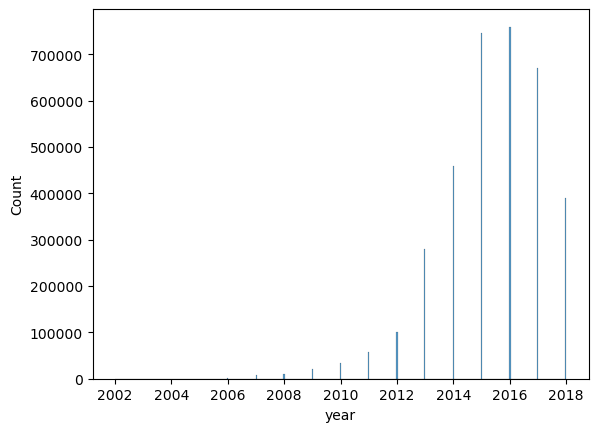

In [85]:
sns.histplot(df_full, x='year')

# Creating Subsets

- Try grouping by asin for reviews alone and checking value counts to see if theres any product with sufficient reviews for analysis.
- Try grouping by brand
- Try grouping by category
- Try ...?

### Subset by asin (product)

In [86]:
overall_by_asin_counts = df_full.groupby('asin')['overall'].value_counts(normalize=False).unstack(1)
overall_by_asin_counts = overall_by_asin_counts.fillna(0).astype(int)
overall_by_asin_counts

overall,1.0,2.0,3.0,4.0,5.0
asin,,,,,
0681727810,0,0,0,0,4
0853347867,0,0,0,0,2
4639725043,11,3,9,15,57
4639725183,3,3,2,4,46
4858582000,0,0,0,1,2
...,...,...,...,...,...
B010R417MI,0,1,0,1,0
B010R4B8OU,0,0,0,0,2
B010R544D6,0,0,0,0,2


In [87]:
overall_by_asin_perc = df_full.groupby('asin')['overall'].value_counts(normalize=True).unstack(1)
overall_by_asin_perc = overall_by_asin_perc.fillna(0).round(3)#.astype(int)
overall_by_asin_perc

overall,1.0,2.0,3.0,4.0,5.0
asin,,,,,
0681727810,0.000,0.000,0.000,0.000,1.000
0853347867,0.000,0.000,0.000,0.000,1.000
4639725043,0.116,0.032,0.095,0.158,0.600
4639725183,0.052,0.052,0.034,0.069,0.793
4858582000,0.000,0.000,0.000,0.333,0.667
...,...,...,...,...,...
B010R417MI,0.000,0.500,0.000,0.500,0.000
B010R4B8OU,0.000,0.000,0.000,0.000,1.000
B010R544D6,0.000,0.000,0.000,0.000,1.000


<!-- ##### Could do by Pr -->

In [88]:
# Get the 100 products with the most 1 star reviews
asin_most_ones = overall_by_asin_counts[1.0].nlargest(1000)
asin_most_ones

asin
B007JINB0W    1070
B00542YXFW     671
B00BUKL666     458
B00K2RY8GI     429
B000EVMNMI     372
              ... 
B00V3WMJVM      30
B00W2F3LLQ      30
B00W6OFHV0      30
B00XK4JLGW      30
B000FUYCJ0      29
Name: 1.0, Length: 1000, dtype: int64

In [89]:
# Get the 100 products with the most 5 star reviews
asin_most_fives = overall_by_asin_counts[5.0].nlargest(1000)
asin_most_fives

asin
B00BUKL666    8001
B008QMX2SG    6245
B00D3M2QP4    6228
B00542YXFW    5708
B000F4DKAI    4934
              ... 
B000BW5FMU     304
B001ELLB16     304
B005GXQ244     304
B00631TI2Q     304
B00INC2UPK     304
Name: 5.0, Length: 1000, dtype: int64

In [90]:
# Select product ids that appear in both overall review counts
filter_asin_most_shared = asin_most_fives.index.isin(asin_most_ones.index)
filter_asin_most_shared[:5]

array([ True,  True,  True,  True,  True])

In [91]:
# Getting overlapping columns
asin_most_shared = asin_most_fives.index[filter_asin_most_shared]
print(asin_most_shared[:5])
len(asin_most_shared)

Index(['B00BUKL666', 'B008QMX2SG', 'B00D3M2QP4', 'B00542YXFW', 'B000F4DKAI'], dtype='object', name='asin')


533

In [92]:
# Saving final selected asin ids
selected_product_asins = asin_most_shared.copy()
len(selected_product_asins)

533

In [93]:
# Get filtered dataframe of only these products
df_shared = df_full.loc[ df_full['asin'].isin(selected_product_asins)]
# Reset Index
df_shared = df_shared.reset_index(drop=True)
df_shared

,asin,reviewerID,reviewText,summary,overall,year
0,B0001ES9FI,A1F07TCKQT2C50,I just got the senseo coffee machine and it came with the medium and light coffee. I ordered the dark myself. I much prefer the dark. Its richer and has a fuller body. Its stronger. If you like st...,Dark roast is my favorite,4.0,2004
1,B0001ES9FI,A19U7XR8BCVGBN,"I have had my Senseo for a little over a week. I agree with most of the other reviewers, that it is the best coffee I have made at home. I enjoy having several mugs of coffee in the morning, but...",Great Cup of Coffee - Less Caffeine,4.0,2004
2,B0001ES9FI,A1R9ENDDUT7CM0,"This coffee machine is probably the best coffee maker I've ever used, so long as you use their coffee pods. I purchased mine from Target...what a disaster since they don't keep consistent stock o...",Don't Purchase from Target,5.0,2004
3,B0001ES9FI,A13A105B1M45W4,I've had my Senseo for about 2 months and love it. I'm the only coffee drinker in my family so making a pot of coffee is a waste for me. This is quick and easy and great tasting. Pods are expen...,Awesome Coffee,5.0,2004
4,B0001ES9FI,A23ZRFLO4FCVXE,"What more can be said? Good, clean, full bodied... it sounds like a commercial. It's so good that, I'm sorry to say, even my kids like it.",Good coffee,5.0,2004
...,...,...,...,...,...,...
708700,B010OITYIQ,A1QZAYTL1DUKRI,"I am no expert on tea and only have it a few times a week, but for those that like a natural 'comes from the earth' kind of taste, you will enjoy this tea.",A Very Natural Taste,5.0,2018
708701,B010OITYIQ,AX9GG664AI8XN,Bought it for my daughter. She liked it.,She liked it.,5.0,2018
708702,B010OITYIQ,A1V2LR7H4XRVNK,"High quality product. They give you a freebie for leaving a review, so it's essentially a BOGO offer.",Good matcha.,5.0,2018
708703,B010OITYIQ,A3JBXHCRORQKGB,"Great taste, quality and price. Ill be ordering again.",Great Value,5.0,2018


In [94]:
# Check how many reviews for most common product
top_25_most_reviews = df_shared['asin'].value_counts().head(25)
top_25_most_reviews

B00BUKL666    10314
B00542YXFW     8631
B008QMX2SG     8008
B00D3M2QP4     7987
B000F4DKAI     5965
B0001LO3FG     5961
B00DS842HS     5834
B002HQCWYM     5829
B000EVMNMI     5273
B00CPZPYLS     5213
B000H2XXRS     5184
B00EDHW7K2     5163
B00C1LXBFC     5096
B00PFDH0IC     5007
B005K4Q1T0     4548
B006CNTR6W     4435
B007JINB0W     4363
B006IOKA9S     4258
B00XA8XWGS     4184
B00WBUX2UM     4084
B00R7PWK7W     4052
B00M2OGS08     4049
B00K2RY8GI     3775
B00KSN9TME     3514
B009OWOKFQ     3408
Name: asin, dtype: int64

#### Filter Metadata by Selected asins

In [95]:
# Set index of df_meta for easy slicing
df_meta = df_meta.set_index('asin')
df_meta

,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
asin,,,,,,,,,,,,,,,,,,,,,,,,
B00BUKL666,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...",0,0,0,0,0,0,0,1,0,0,1,0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]"
B008QMX2SG,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...",0,0,0,0,0,0,0,1,0,0,1,0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]"
B00D3M2QP4,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...",0,0,0,0,0,0,0,1,0,0,0,0,"[Grocery & Gourmet Food, Breakfast Foods, Breakfast & Cereal Bars, Cereal]"
B00542YXFW,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha","'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplements hav

In [96]:
# Filter for only selected products from reviews
df_meta_shared = df_meta.loc[selected_product_asins].reset_index(drop=False)
df_meta_shared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 25 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   asin                                             533 non-null    object
 1   category                                         533 non-null    object
 2   description                                      465 non-null    object
 3   title                                            533 non-null    object
 4   brand                                            526 non-null    object
 5   feature                                          143 non-null    object
 6   rank                                             533 non-null    object
 7   main_cat                                         533 non-null    object
 8   price                                            438 non-null    object
 9   imageURL                                   

In [97]:
cols_keep_meta = ['asin','title','brand','category']
df_meta_shared[cols_keep_meta]

,asin,title,brand,category
0,B00BUKL666,"KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
1,B008QMX2SG,"Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
2,B00D3M2QP4,"KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal
3,B00542YXFW,"Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag",Davidson's Tea,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha"
4,B000F4DKAI,"Twinings of London English Afternoon Black Tea Bags, 20 Count (Pack of 6)",Twinings,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Green"
...,...,...,...,...
528,B00250M2ZY,Bobs Sweet Stripes Soft Peppermint Balls (51 Ounce),Bobs,Grocery & Gourmet Food; Candy & Chocolate; Mints
529,B006E9PPCE,"Stash Tea Gunpowder Green Loose Leaf Tea, 16 Ounce Pouch",Stash Tea,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Black"
530,B00I6R0KLS,"Beantown Roasters K-Cup Variety Pack made up of 11 Artisan Coffees &quot;No Decaf&quot; for Keurig, Pack of 96",Beantown Roasters,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
531,B000BW5FMU,"Donckels Cocoa Dusted Belgian Chocolate Truffles, 3 Count, 48 Oz",Donckels,Grocery & Gourmet Food; Candy & Chocolate; Chocolate & Fudge; Chocolate Truffles


In [98]:
# Save final reviews dataframe with select metadata cols added
df = pd.merge(df_shared, df_meta_shared[cols_keep_meta], on='asin')
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B0001ES9FI,A1F07TCKQT2C50,I just got the senseo coffee machine and it came with the medium and light coffee. I ordered the dark myself. I much prefer the dark. Its richer and has a fuller body. Its stronger. If you like st...,Dark roast is my favorite,4.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
1,B0001ES9FI,A19U7XR8BCVGBN,"I have had my Senseo for a little over a week. I agree with most of the other reviewers, that it is the best coffee I have made at home. I enjoy having several mugs of coffee in the morning, but...",Great Cup of Coffee - Less Caffeine,4.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
2,B0001ES9FI,A1R9ENDDUT7CM0,"This coffee machine is probably the best coffee maker I've ever used, so long as you use their coffee pods. I purchased mine from Target...what a disaster since they don't keep consistent stock o...",Don't Purchase from Target,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
3,B0001ES9FI,A13A105B1M45W4,I've had my Senseo for about 2 months and love it. I'm the only coffee drinker in my family so making a pot of coffee is a waste for me. This is quick and easy and great tasting. Pods are expen...,Awesome Coffee,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
4,B0001ES9FI,A23ZRFLO4FCVXE,"What more can be said? Good, clean, full bodied... it sounds like a commercial. It's so good that, I'm sorry to say, even my kids like it.",Good coffee,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
...,...,...,...,...,...,...,...,...,...
708700,B00ZEA5ESY,AVQMXBMSO11L4,"I received a Savor box as a gift for my first sons birth, and will get another one for my second! The color is super nice and vibrant. The materials are premium quality and the whole thing feels v...",Beautiful and high quality keepsake,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708701,B00ZEA5ESY,A328LC0UXY12DC,Delicious!!,Yummy,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708702,B00ZEA5ESY,A3OMMZ22V7Q8SD,Tasty energy packed treat.,tasty,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708703,B00ZEA5ESY,A338LPLJX279CD,so delicious I love them,yum,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars


In [99]:
# Getting top 10 most common brands to visualize counts distrubtion
most_common_brand_counts = df['brand'].value_counts().head(10)
most_common_brand_counts

KIND                              37482
Twinings                          22957
Viva Naturals                     16824
Nutiva                            13807
Planters                          12265
Davidson's Tea                    10376
Healthworks                       10258
Death Wish Coffee Co.              8103
Green Mountain Coffee Roasters     7933
Crazy Cups                         7919
Name: brand, dtype: int64

In [100]:
# df.groupby()

## Saving Most Reviewed Common Products Reviews & Metadata CSV 

In [101]:
keep_meta_cols = ['asin','title','brand','description','category','feature','main_cat','imageURL','imageURLHighRes']
df_meta_shared[keep_meta_cols]

,asin,title,brand,description,category,feature,main_cat,imageURL,imageURLHighRes
0,B00BUKL666,"KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...",Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U..."
1,B008QMX2SG,"Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...",Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf..."
2,B00D3M2QP4,"KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...",Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa..."
3,B00542YXFW,"Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag",Davidson's Tea,"'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diag...","Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/31-bynr4YrL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/31kM2giWN6L._SS40_.jpg'","'https://images-na.ssl-images-amazon.com/images/I/31-bynr4YrL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/31kM2giWN6L.jpg'"
4,B000F4DKAI,"Twinings of London English Afternoon Black Tea Bags, 20 Count (Pack of 6)",Twinings,"'First started as much needed refreshment between lunch and dinner, afternoon tea is now an important fixture of British life. Twinings English Afternoon Tea is bright in color with a brisk and re...","Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Green",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/51lhEXUwJTL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51iQKeNBfyL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/51lhEXUwJTL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51iQKeNBfyL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41y38tUWNx..."
...,...,...,...,...,...,...,...,...,...
528,B00250M2ZY,Bobs Sweet Stripes Soft Peppermint Balls (51 Ounce),Bobs,"""Get a tub of 290 pieces of Bob's Sweet Stripes SO

In [102]:
# Get rid of fake outer lists from string columns 
list_cols  =['description','imageURL','imageURLHighRes', 'feature']
# ast.literal_eval errored so switching tactics
# df_meta_shared['description-text'] = df_meta_shared['description'].fillna('').map(lambda x: ast.literal_eval(x))#[0])

for col in list_cols:
    df_meta_shared[col] = df_meta_shared[col].fillna('').map(
    lambda x: x.replace('[','').replace(']',''))
df_meta_shared

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...",0,0,0,0,0,0,0,1,0,0,1,0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]"
1,B008QMX2SG,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...",0,0,0,0,0,0,0,1,0,0,1,0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]"
2,B00D3M2QP4,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...",0,0,0,0,0,0,0,1,0,0,0,0,"[Grocery & Gourmet Food, Breakfast Foods, Breakfast & Cereal Bars, Cereal]"
3,B00542YXFW,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha","'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplements have not been evaluated by t

# 📌 BOOKMARK END OF 02/07/24

- Resume with the subset selection after loading the files saved below.

In [103]:
# df_meta_shared.duplicated().sum()

In [104]:
df_meta_shared.duplicated(subset=['asin']).sum()

0

In [105]:
df.duplicated(subset=['asin','reviewerID','reviewText']).sum()

0

#### Creating Clean Subset Folder

In [106]:
fpath_meta_subset = FPATHS['data']['subset']['metadata_csv']
fpath_meta_subset

'data/subset/amazon-metadata-subset-grocery-most-common-products.csv.gz'

In [107]:
# folder_subset = "subset/"
# os.makedirs(folder_subset, exist_ok=True)

In [108]:
# Save metadata
# fpath_meta = folder_subset+'amazon-metadata-subset-grocery-most-common-products.csv.gz'
compression_params = {'method': 'gzip', 'compresslevel': 9}
df_meta_shared.to_csv(fpath_meta, index=False, compression=compression_params)

In [109]:
pd.read_csv(fpath_meta)

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...",0,0,0,0,0,0,0,1,0,0,1,0,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"
1,B008QMX2SG,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...",0,0,0,0,0,0,0,1,0,0,1,0,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"
2,B00D3M2QP4,Grocery & Gourmet Food; Breakfast Foods; Breakfast & Cereal Bars; Cereal,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...",0,0,0,0,0,0,0,1,0,0,0,0,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']"
3,B00542YXFW,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Tea; Matcha","'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplem

In [110]:
# Get fpath for reviews subset
fpath_reviews_subset = FPATHS['data']['subset']['reviews-subset_most-commonly-reviewed_csv']
fpath_reviews_subset

'data/subset/amazon-reviews-subset-grocery-most-common-products.csv.gz'

In [111]:
# Save reviews
# fpath_reviews = folder_subset+'amazon-reviews-subset-grocery-most-common-products.csv.gz'
df.to_csv(fpath_reviews_subset, index=False, compression=compression_params)

In [112]:
pd.read_csv(fpath_reviews_subset)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B0001ES9FI,A1F07TCKQT2C50,I just got the senseo coffee machine and it came with the medium and light coffee. I ordered the dark myself. I much prefer the dark. Its richer and has a fuller body. Its stronger. If you like st...,Dark roast is my favorite,4.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
1,B0001ES9FI,A19U7XR8BCVGBN,"I have had my Senseo for a little over a week. I agree with most of the other reviewers, that it is the best coffee I have made at home. I enjoy having several mugs of coffee in the morning, but...",Great Cup of Coffee - Less Caffeine,4.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
2,B0001ES9FI,A1R9ENDDUT7CM0,"This coffee machine is probably the best coffee maker I've ever used, so long as you use their coffee pods. I purchased mine from Target...what a disaster since they don't keep consistent stock o...",Don't Purchase from Target,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
3,B0001ES9FI,A13A105B1M45W4,I've had my Senseo for about 2 months and love it. I'm the only coffee drinker in my family so making a pot of coffee is a waste for me. This is quick and easy and great tasting. Pods are expen...,Awesome Coffee,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
4,B0001ES9FI,A23ZRFLO4FCVXE,"What more can be said? Good, clean, full bodied... it sounds like a commercial. It's so good that, I'm sorry to say, even my kids like it.",Good coffee,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
...,...,...,...,...,...,...,...,...,...
708700,B00ZEA5ESY,AVQMXBMSO11L4,"I received a Savor box as a gift for my first sons birth, and will get another one for my second! The color is super nice and vibrant. The materials are premium quality and the whole thing feels v...",Beautiful and high quality keepsake,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708701,B00ZEA5ESY,A328LC0UXY12DC,Delicious!!,Yummy,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708702,B00ZEA5ESY,A3OMMZ22V7Q8SD,Tasty energy packed treat.,tasty,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708703,B00ZEA5ESY,A338LPLJX279CD,so delicious I love them,yum,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars


- Later to do

# Subsetting from Most Common Product Reviews

### Find Overlap of Products with Most Number of 1s and 5s

### Subset by Brand

In [113]:
# Get the distribution of overall ratings for each brand
overall_by_brand_counts = df.groupby('brand')['overall'].value_counts(normalize=False).unstack(1)
overall_by_brand_counts.head(10)

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
4th & Heart,113,55,91,144,1397
9GreenBox,237,126,159,203,778
ALO,46,33,60,135,987
Altoids,33,17,25,81,868
Amazing Grass,38,21,39,61,319
Amish Country Popcorn,57,46,88,92,610
Amore,32,20,24,62,356
Amoretti,95,49,60,70,383
Amy & Brian,47,25,53,62,336


In [114]:
# Finding brands with the most one-star reviews
most_negative_brand_counts = overall_by_brand_counts.sort_values(1.0, ascending=False).head(100)
most_negative_brand_counts

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
KIND,1723,1153,1921,3638,29047
Miracle Noodle,1070,367,453,605,1868
Crazy Cups,867,622,980,1195,4255
Twinings,833,584,1041,2046,18453
Davidson's Tea,767,606,808,1280,6915
...,...,...,...,...,...
Taylors of Harrogate,128,85,122,191,1285
Numi Organic Tea,126,88,153,265,1553
Lakanto,126,86,145,249,1583


In [115]:
# Get the distribution of overall ratings for each brand
overall_by_brand_perc = df.groupby('brand')['overall'].value_counts(normalize=True).unstack(1)
overall_by_brand_perc.head(10)

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
4th & Heart,0.062778,0.030556,0.050556,0.080000,0.776111
9GreenBox,0.157685,0.083832,0.105788,0.135063,0.517631
ALO,0.036479,0.026170,0.047581,0.107058,0.782712
Altoids,0.032227,0.016602,0.024414,0.079102,0.847656
Amazing Grass,0.079498,0.043933,0.081590,0.127615,0.667364
Amish Country Popcorn,0.063830,0.051512,0.098544,0.103024,0.683091
Amore,0.064777,0.040486,0.048583,0.125506,0.720648
Amoretti,0.144597,0.074581,0.091324,0.106545,0.582953
Amy & Brian,0.089866,0.047801,0.101338,0.118547,0.642447


In [116]:
# Finding brands with the most one-star reviews
most_negative_brand_perc = overall_by_brand_perc.sort_values(1.0, ascending=False).head(20)
most_negative_brand_perc[[1.0,5.0]]

overall,1.0,5.0
brand,,
Miracle Noodle,0.245244,0.428146
Tropicana,0.226651,0.515945
Epic Provisions,0.201272,0.470792
Primal Kitchen,0.198899,0.576050
Sincerely Nuts,0.175309,0.614815
Java Factory,0.169685,0.503018
9GreenBox,0.157685,0.517631
Zevia,0.153931,0.562947
Beantown Roasters,0.153846,0.505061


In [117]:
# Getting Brands with 
most_negative_brand_review_counts_stars  = most_negative_brand_counts[[1.0,5.0]].sum(axis=1).sort_values(ascending=False)
top_100_most_1_star_5_star_reviews = most_negative_brand_review_counts_stars.head(100)
top_100_most_1_star_5_star_reviews

brand
KIND                 30770
Twinings             19286
Viva Naturals        14553
Nutiva               11809
Planters              9672
                     ...  
Lily`s Sweets          728
Tropicana              652
SodaStream             652
Sincerely Nuts         640
World Confections      622
Length: 100, dtype: int64

### 🚨NOTE EOD 02/07/24 - review final selection logic below

In [118]:
overlapping_counts = most_negative_brand_counts[most_negative_brand_counts.index.isin(top_100_most_1_star_5_star_reviews.index)]
overlapping_counts

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
KIND,1723,1153,1921,3638,29047
Miracle Noodle,1070,367,453,605,1868
Crazy Cups,867,622,980,1195,4255
Twinings,833,584,1041,2046,18453
Davidson's Tea,767,606,808,1280,6915
...,...,...,...,...,...
Taylors of Harrogate,128,85,122,191,1285
Numi Organic Tea,126,88,153,265,1553
Lakanto,126,86,145,249,1583


In [119]:
overlapping_counts.sort_values(1.0, ascending=False).head(20)

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
KIND,1723,1153,1921,3638,29047
Miracle Noodle,1070,367,453,605,1868
Crazy Cups,867,622,980,1195,4255
Twinings,833,584,1041,2046,18453
Davidson's Tea,767,606,808,1280,6915
Viva Naturals,604,303,498,1470,13949
Lindt,539,213,255,369,4332
Haribo,534,249,351,579,5341
Stur,528,401,519,760,4819


<Axes: ylabel='brand'>

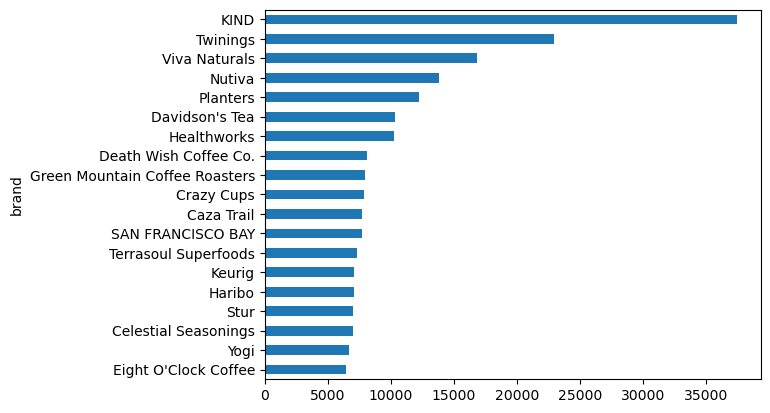

In [120]:
overlapping_counts.sum(axis=1).sort_values().tail(19).plot(kind='barh')

In [121]:
# col = "KIND"
# overlapping_counts.loc[col].plot(kind='barh', title =col)

In [122]:
def get_value_counts_perc(df_final, col='overall',reset_index=False):
    temp = pd.DataFrame({'Counts':df_final[col].value_counts(),
                         'Percent':df_final[col].value_counts(1)*100})
    temp = temp.sort_index()
    temp.index.name = col
    if reset_index:
        temp = temp.reset_index(drop=False)
    return temp

In [123]:
get_value_counts_perc(df)

,Counts,Percent
overall,,
1.0,44041,6.214292
2.0,27504,3.880881
3.0,42602,6.011246
4.0,77051,10.872084
5.0,517507,73.021497


In [124]:
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B0001ES9FI,A1F07TCKQT2C50,I just got the senseo coffee machine and it came with the medium and light coffee. I ordered the dark myself. I much prefer the dark. Its richer and has a fuller body. Its stronger. If you like st...,Dark roast is my favorite,4.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
1,B0001ES9FI,A19U7XR8BCVGBN,"I have had my Senseo for a little over a week. I agree with most of the other reviewers, that it is the best coffee I have made at home. I enjoy having several mugs of coffee in the morning, but...",Great Cup of Coffee - Less Caffeine,4.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
2,B0001ES9FI,A1R9ENDDUT7CM0,"This coffee machine is probably the best coffee maker I've ever used, so long as you use their coffee pods. I purchased mine from Target...what a disaster since they don't keep consistent stock o...",Don't Purchase from Target,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
3,B0001ES9FI,A13A105B1M45W4,I've had my Senseo for about 2 months and love it. I'm the only coffee drinker in my family so making a pot of coffee is a waste for me. This is quick and easy and great tasting. Pods are expen...,Awesome Coffee,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
4,B0001ES9FI,A23ZRFLO4FCVXE,"What more can be said? Good, clean, full bodied... it sounds like a commercial. It's so good that, I'm sorry to say, even my kids like it.",Good coffee,5.0,2004,"Senseo Dark Roast Coffee Pods, 4.41 Ounce, 18-Count Pods (Pack of 4)",Senseo,"Grocery & Gourmet Food; Beverages; Coffee, Tea & Cocoa; Coffee; Single-Serve Capsules & Pods"
...,...,...,...,...,...,...,...,...,...
708700,B00ZEA5ESY,AVQMXBMSO11L4,"I received a Savor box as a gift for my first sons birth, and will get another one for my second! The color is super nice and vibrant. The materials are premium quality and the whole thing feels v...",Beautiful and high quality keepsake,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708701,B00ZEA5ESY,A328LC0UXY12DC,Delicious!!,Yummy,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708702,B00ZEA5ESY,A3OMMZ22V7Q8SD,Tasty energy packed treat.,tasty,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars
708703,B00ZEA5ESY,A338LPLJX279CD,so delicious I love them,yum,5.0,2018,"KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,Grocery & Gourmet Food; Snack Foods; Bars; Nut Bars


For KIND there are 37482 total reviews.


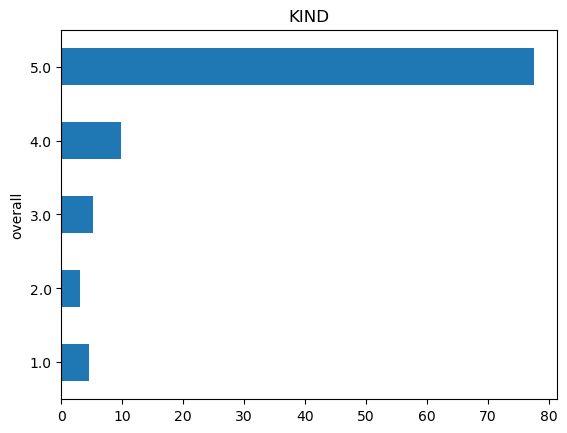



For Miracle Noodle there are 4363 total reviews.


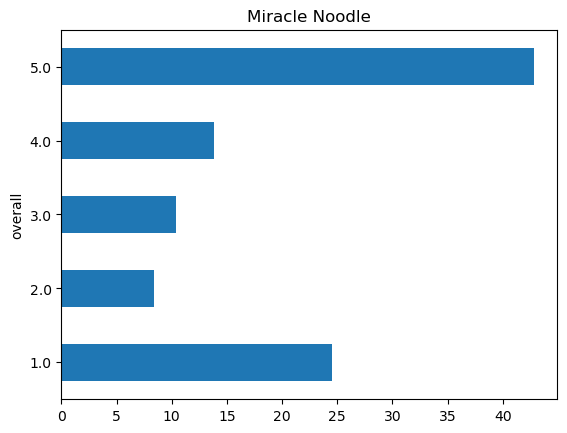



For Twinings there are 22957 total reviews.


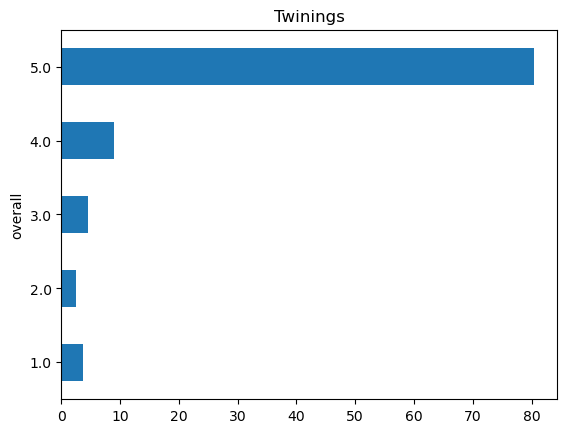

In [125]:
### Debating options (look at cell above and below)
options = ['KIND',#but very imbalanced
           'Miracle Noodle', # 
           'Twinings'
          ]

# col = "KIND"
for col in options:
    temp_df = df.loc[ df['brand']==col].reset_index(drop=True)
    # overlapping_counts.loc[col].plot(kind='barh', title =col) # Got confused as to this vs temp_df below
    # plt.show()
    # temp_df = temp_df.rename({'index':'overall'})
    
    col_counts = get_value_counts_perc(temp_df, col='overall')
    col_counts['brand'] = col
    print(f"For {col} there are {col_counts['Counts'].sum()} total reviews.")

    plt.figure()
    # col_counts['Percent'].plot(kind='barh')
    col_counts['Percent'].plot(kind='barh', title =col)
    plt.show()
    print('='*80,'\n\n')


## BOOKMARK: Decide final brand(s)

In [126]:
# raise Exception('stop here for now')

In [127]:
SELECTED_BRAND  = "Miracle Noodle"
df_final = df.loc[ df['brand']==SELECTED_BRAND].reset_index(drop=True)
df_final

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B007JINB0W,A2G943N32RET14,"I have lost over 105 pounds and low calorie foods are important to me, the spinach noodles are the best tasting miracle noodles of the bunch. Just like any other Shirataki noodles you have to rin...",best one i have tried,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
1,B007JINB0W,A3EHCTP6LQOX7E,"They were O.K. I would ""Not"" buy them again though. The taste was strange, because I could not get past the smell of them when they are first opened up. And the smell stayed in my nose for a lo...",miracle?,3.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
2,B007JINB0W,A2FYEJJ44RTBGV,"Take time to prepare properly (rinse, blanch,dry fry) and you wil find that they taste like whatever else you're eating. I also suggest snipping them into small lengths as you drop them in the boi...",Best diet food ever,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
3,B007JINB0W,A1SAC729TVBB8M,"I use this as a substitute for pasta. Have it with tomatoes, peppers, garlic and parmesan cheese. It'll never replace the real thing for me but, can't beat the calories.",Review,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4,B007JINB0W,AYDHHE3PWRBGI,The noodles are fine - my rating has nothing to do with the person or place we bought them from. We have had Shiratake noodles before - these are not quite as yummy as the others we have purchased.,Shirataki noodles,3.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A1SKVZRHLR5FDM,These are really good and no calories. Works great on my weight watchers plan.,Yummy,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4359,B007JINB0W,A3PQJ32GSDJ42Q,I can usually handle any taste or texture. I read the reviews but I know I can generally us whatever and get by. Even used an Alfredo sauce and found it so horrible I just couldn't force myself to...,Worse food product I have EVER put in my mouth,1.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4360,B007JINB0W,A2NCWAZKP84T7Y,I am thrilled with these noodles! Im a t1 diabetic and as promised on the package there are no carbohydrates. My blood sugar was 118 before I ate them and 120 an hour after.,Delicious and guilt free,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4361,B007JINB0W,A2M7VOHJJYCC4Q,"Do d not enjoy, following wed the directions and was disappointing noted unfortunately....",Slimy not very good,1.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki


In [128]:
# pd.DataFrame({'# Null':df_final['overall'].value_counts(),'% Null':df_final['overall'].value_counts(1)})

In [129]:
df_final['overall'].value_counts()

5.0    1868
1.0    1070
4.0     605
3.0     453
2.0     367
Name: overall, dtype: int64

In [130]:
df_final['overall'].value_counts(1)

5.0    0.428146
1.0    0.245244
4.0    0.138666
3.0    0.103828
2.0    0.084116
Name: overall, dtype: float64

In [131]:
# SELECTED_BRAND  = "Tropicana"#$"KIND"
# new_column_order = [
#     #'text'.
#     'reviewText',
#     'summary',    
#     'overall',
#     'brand',
#     'title']

#, new_column_order]
# Shuffling Rows & Reset Index
df_final = df_final.sample(frac=1, replace=False)
df_final = df_final.reset_index(drop=True)
df_final

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3.0,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of...,Its an awesome substitute.,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured. Also smells really really bad.,would not recomend,1.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Five Stars,5.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4360,B007JINB0W,A3I2YF0MXB7P0B,"I like these noodles but the spinach ones just taste odd. They have a bitter flavor compared to the other ones. I don't think it tastes like Spinach, it just tastes bitter and odd. Now I understan...","Not awful, but now I know why these were on sale.",2.0,2013,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4361,B007JINB0W,A2UELLFLITPMT1,Truly horrific. Like eating dead worms.,Don't even try it.,1.0,2017,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki


In [132]:
df_final['overall'].value_counts()

5.0    1868
1.0    1070
4.0     605
3.0     453
2.0     367
Name: overall, dtype: int64

### Save Final Selected Reviews

In [133]:
fname = FPATHS['data']['subset']['reviews-subset_selected-brand_csv']
fname

'data/subset/amazon-reviews-subset-brand-Miracle Noodle.csv'

In [ ]:
# # folder_subset = "subset/"
# # os.makedirs(folder_subset, exist_ok=True)

# fname = f"{folder_subset}amazon-reviews-subset-brand-{SELECTED_BRAND}.csv.gz"
# fname

In [134]:
if fname.endswith('gz'):
    compression = compression_params
else:
    compression = None
df_final.to_csv(fname, compression=compression,
                index=False)
pd.read_csv(fname)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3.0,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of...,Its an awesome substitute.,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured. Also smells really really bad.,would not recomend,1.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Five Stars,5.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4360,B007JINB0W,A3I2YF0MXB7P0B,"I like these noodles but the spinach ones just taste odd. They have a bitter flavor compared to the other ones. I don't think it tastes like Spinach, it just tastes bitter and odd. Now I understan...","Not awful, but now I know why these were on sale.",2.0,2013,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
4361,B007JINB0W,A2UELLFLITPMT1,Truly horrific. Like eating dead worms.,Don't even try it.,1.0,2017,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki
